In [1]:
import pyautogui
import time
from PIL import ImageGrab
import numpy as np
from color_detection.color_difference import ColorDifferenceDetector
from utils.mouse_event import MouseEvent
from utils.math_util import trans_ltrb_to_xywh


### 获取屏幕位置

In [302]:
mouse_event = MouseEvent()
region = mouse_event.get_region()
print(region)


请点击要选择区域的左上角和右下角...
(158, 316, 666, 828)


### 截图发送给PIL


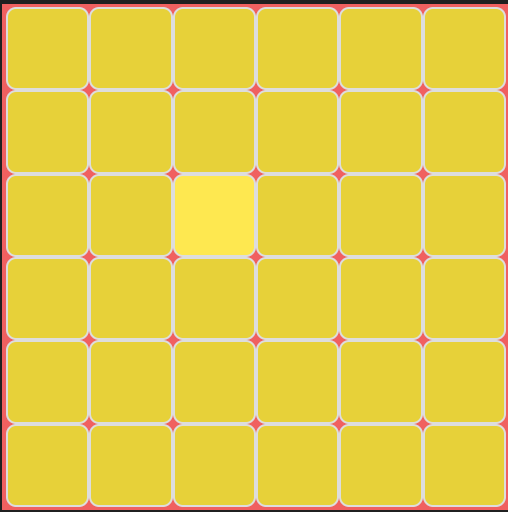

In [303]:
screenshot = ImageGrab.grab(bbox=region)
screenshot

In [304]:
import cv2

def show_image(title,image):
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [305]:

# 读取图像
image = cv2.cvtColor(np.array(screenshot), cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_image("gray",gray)

In [306]:
# 增强对比度（直方图均衡）
equalized = cv2.equalizeHist(gray)
show_image("equalized",equalized)

In [307]:
# 二值化处理
binary = cv2.adaptiveThreshold(
    equalized,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    3,  # 邻域大小
    3    # 常数差值
)
show_image("binary",binary)

In [308]:

# 使用形态学操作来清理图像
kernel = np.ones((3,3), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
show_image("binary",binary)

In [309]:
binary = cv2.dilate(binary, np.ones((7,7), np.uint8), iterations=1)

show_image("binary",binary)

In [311]:

binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
show_image("binary",binary)


In [313]:

# 查找轮廓
contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


# 获取图像宽度
img_width = image.shape[1]
squares = []
img_cp = image.copy()
index = 0
# 在图像上标注
for i, cnt in enumerate(contours):

    x, y, w, h = cv2.boundingRect(cnt)
    
    # 判断轮廓是否过大
    if w > (img_width * 2/3):
        continue
    # 判断轮廓是否过小
    if w < (img_width*0.05):
        continue

    new_rect = (x, y, w, h)


    squares.append((x,y,w,h))
    cv2.rectangle(img_cp, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img_cp, str(index), (x+5, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    index += 1

# 显示图像（本地运行时使用）
cv2.imshow("Labeled Grid", img_cp)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [263]:
def get_center_point(x,y,w,h):
    return int(x+w/2),int(y+h/2)




In [314]:
from collections import defaultdict

def find_different_block(image,squares):        
    colors = defaultdict(list)
    for x,y,w,h in squares:
        center_x,center_y = get_center_point(x,y,w,h)
        color = tuple(image[center_y, center_x])
        colors[color].append((center_x,center_y))
    
    for color,positions in colors.items():
        if len(positions) == 1:
            return positions[0]





In [315]:
x,y=find_different_block(image,squares)

print(x,y)

214 215


In [316]:
pyautogui.moveTo(x+region[0],y+region[1])
pyautogui.click()
